In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
import copy
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [14]:
print("=== CARGA DE DATOS BASE ===")

# 1) Dataset base (valores reales, sin log)
df_final = pd.read_csv("df_final_log_transform.csv")

# Aseguramos tipos
df_final['SKU'] = df_final['SKU'].astype(str).str.strip()
df_final['Fecha'] = pd.to_datetime(df_final['Fecha'])

print("Shape df_final (base):", df_final.shape)
print(df_final.head(3))

# 2) Dataset de ventas detalladas (para traer la categoría)
df_det = pd.read_csv("ventas_detalladas_2025_v3_1.csv")
df_det['SKU'] = df_det['SKU'].astype(str).str.strip()

# Mapeo SKU -> Categoria (uno por SKU)
sku_cat = (
    df_det[['SKU', 'Categoria']]
    .drop_duplicates()
    .sort_values(['Categoria', 'SKU'])
)

print("SKUs con categoría:", sku_cat.shape[0])
print(sku_cat.head())

# 3) MERGE: agregar 'Categoria' al df_final
df_final = df_final.merge(sku_cat, on='SKU', how='left')

# Orden importante para rolling / shift
df_final = df_final.sort_values(['SKU', 'Fecha']).reset_index(drop=True)

missing_cat = df_final['Categoria'].isna().sum()
print(f"Filas sin categoría después del merge: {missing_cat}")
# Si quieres evitar problemas, puedes rellenar:
df_final['Categoria'] = df_final['Categoria'].fillna('SinCategoria')

df_final.head()


=== CARGA DE DATOS BASE ===
Shape df_final (base): (24013, 11)
        SKU      Fecha  Demanda_Total  Precio_Prom_Venta  Num_Transacciones  \
0  SKU-0001 2025-01-05             48           9.962500                 16   
1  SKU-0001 2025-01-19            109           9.852632                 38   
2  SKU-0001 2025-02-02            131           9.649057                 53   

   Num_Feriados  Num_Dias_Pago  Num_Dias_Promocion  Precio_base  Rotacion_Cod  \
0             0              0                   0         10.0             3   
1             0              0                   0         10.0             3   
2             0              5                   0         10.0             3   

   Target_Demanda_Futura  
0                  109.0  
1                  131.0  
2                  102.0  
SKUs con categoría: 1000
           SKU  Categoria
97    SKU-0001  Abarrotes
65    SKU-0002  Abarrotes
229   SKU-0003  Abarrotes
225   SKU-0004  Abarrotes
2398  SKU-0395  Abarrotes
Filas 

,SKU,Fecha,Demanda_Total,Precio_Prom_Venta,Num_Transacciones,Num_Feriados,Num_Dias_Pago,Num_Dias_Promocion,Precio_base,Rotacion_Cod,Target_Demanda_Futura,Categoria
0,SKU-0001,2025-01-05,48,9.962500,16,0,0,0,10.0,3,109.0,Abarrotes
1,SKU-0001,2025-01-19,109,9.852632,38,0,0,0,10.0,3,131.0,Abarrotes
2,SKU-0001,2025-02-02,131,9.649057,53,0,5,0,10.0,3,102.0,Abarrotes
3,SKU-0001,2025-02-16,102,9.454054,37,0,3,2,10.0,3,126.0,Abarrotes
4,SKU-0001,2025-03-02,126,9.289583,48,0,5,0,10.0,3,115.0,Abarrotes


--- APLICANDO SUAVIZADO (Rolling Mean) SOBRE Demanda_Total ---
Suavizado completado. Shape df_suave: (23035, 12)

--- APLICANDO TRANSFORMACIÓN LOGARÍTMICA (np.log1p) ---
Ejemplo de Demanda_Total vs Demanda_Log:
        SKU      Fecha  Demanda_Total  Demanda_Log
0  SKU-0001 2025-01-05      48.000000     3.891820
1  SKU-0001 2025-01-19      78.500000     4.375757
2  SKU-0001 2025-02-02      96.000000     4.574711
3  SKU-0001 2025-02-16     114.000000     4.744932
4  SKU-0001 2025-03-02     119.666667     4.793032


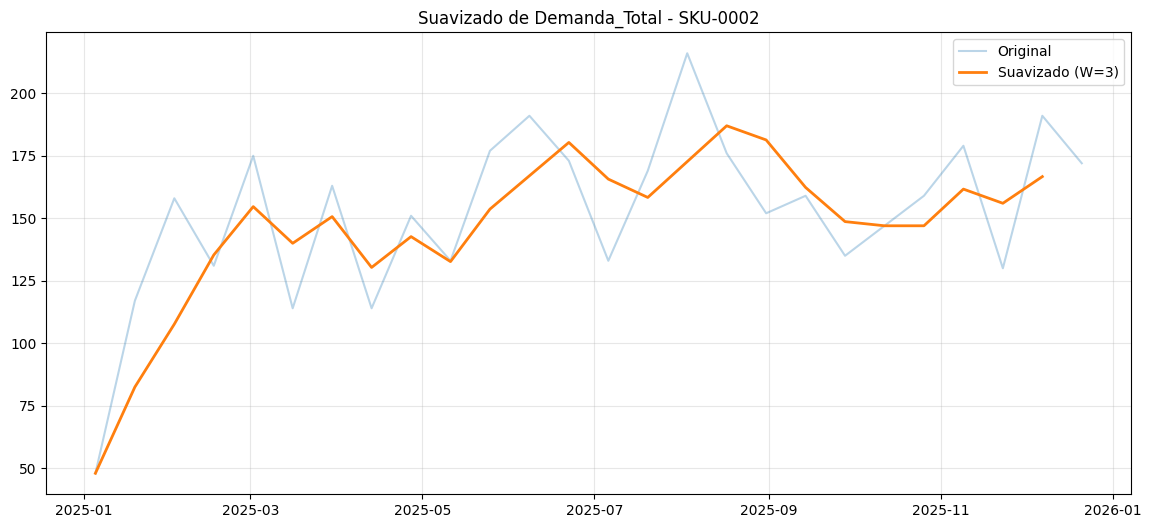

✅ Variable 'df_final' actualizada con datos suavizados + log.


In [15]:
import matplotlib.pyplot as plt

print("--- APLICANDO SUAVIZADO (Rolling Mean) SOBRE Demanda_Total ---")

# Copia de trabajo
df_suave = df_final.copy()

# Ventana de suavizado (quincenas)
WINDOW_SIZE = 3  # puedes tunear este valor

# 1) Suavizar Demanda_Total por SKU
df_suave['Demanda_Total'] = df_suave.groupby('SKU')['Demanda_Total'].transform(
    lambda x: x.rolling(window=WINDOW_SIZE, min_periods=1).mean()
)

# 2) Recalcular Target futuro con la serie ya suavizada
df_suave['Target_Demanda_Futura'] = df_suave.groupby('SKU')['Demanda_Total'].shift(-1)

# 3) Quitar las filas sin target (última quincena de cada SKU)
df_suave = df_suave.dropna(subset=['Target_Demanda_Futura']).reset_index(drop=True)

print("Suavizado completado. Shape df_suave:", df_suave.shape)

# 4) Transformación logarítmica sobre Demanda_Total suavizada
print("\n--- APLICANDO TRANSFORMACIÓN LOGARÍTMICA (np.log1p) ---")
df_suave['Demanda_Log'] = np.log1p(df_suave['Demanda_Total'])
df_suave['Target_Log'] = np.log1p(df_suave['Target_Demanda_Futura'])

print("Ejemplo de Demanda_Total vs Demanda_Log:")
print(df_suave[['SKU', 'Fecha', 'Demanda_Total', 'Demanda_Log']].head())

# (Opcional) Visual de chequeo para un SKU
sku_ejemplo = 'SKU-0002'
datos_orig = df_final[df_final['SKU'] == sku_ejemplo].sort_values('Fecha')
datos_suave = df_suave[df_suave['SKU'] == sku_ejemplo].sort_values('Fecha')

plt.figure(figsize=(14, 6))
plt.plot(datos_orig['Fecha'], datos_orig['Demanda_Total'], label='Original', alpha=0.3)
plt.plot(datos_suave['Fecha'], datos_suave['Demanda_Total'], label=f'Suavizado (W={WINDOW_SIZE})', linewidth=2)
plt.title(f"Suavizado de Demanda_Total - {sku_ejemplo}")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ACTUALIZAMOS VARIABLE GLOBAL
df_final = df_suave
print("✅ Variable 'df_final' actualizada con datos suavizados + log.")


In [16]:
print("\n=== FEATURE ENGINEERING: TIEMPO, DESCUENTO, TENDENCIAS, CATEGORÍA ===")

# 1) Features de calendario
df_final['Mes'] = df_final['Fecha'].dt.month
df_final['Mes_Sin'] = np.sin(2 * np.pi * df_final['Mes'] / 12)
df_final['Mes_Cos'] = np.cos(2 * np.pi * df_final['Mes'] / 12)

# 2) Profundidad del descuento
if 'Precio_base' in df_final.columns and 'Precio_Prom_Venta' in df_final.columns:
    df_final['Descuento_Pct'] = (
        (df_final['Precio_base'] - df_final['Precio_Prom_Venta']) 
        / df_final['Precio_base']
    )
    df_final['Descuento_Pct'] = df_final['Descuento_Pct'].clip(lower=0).fillna(0)
else:
    df_final['Descuento_Pct'] = 0.0

# 3) Tendencia a 6 quincenas por SKU (sobre Demanda_Log ya suavizada)
df_final['Tendencia_6Q'] = df_final.groupby('SKU')['Demanda_Log'].transform(
    lambda x: x.rolling(window=6, min_periods=1).mean().shift(1)
).fillna(0)

# 4) Tendencia a 6 quincenas por CATEGORÍA
df_final['Tendencia_6Q_Cat'] = df_final.groupby('Categoria')['Demanda_Log'].transform(
    lambda x: x.rolling(window=6, min_periods=1).mean().shift(1)
).fillna(0)

# 5) Codificar CATEGORÍA (one-hot)
df_final['Categoria'] = df_final['Categoria'].fillna('SinCategoria')
cat_dummies = pd.get_dummies(df_final['Categoria'], prefix='Cat')
df_final = pd.concat([df_final, cat_dummies], axis=1)
cat_cols = [c for c in df_final.columns if c.startswith('Cat_')]

print("Columnas de categoría codificadas:", cat_cols)

print("\n✅ df_final listo con todas las features.")
print("Shape final:", df_final.shape)
print("Algunas columnas clave:")
print(df_final[['SKU', 'Fecha', 'Categoria', 'Demanda_Total', 'Demanda_Log',
               'Descuento_Pct', 'Mes_Sin', 'Mes_Cos',
               'Tendencia_6Q', 'Tendencia_6Q_Cat']].head())



=== FEATURE ENGINEERING: TIEMPO, DESCUENTO, TENDENCIAS, CATEGORÍA ===
Columnas de categoría codificadas: ['Cat_Abarrotes', 'Cat_Bebidas', 'Cat_Conservas', 'Cat_Licores', 'Cat_Lácteos', 'Cat_Panadería', 'Cat_Snacks']

✅ df_final listo con todas las features.
Shape final: (23035, 27)
Algunas columnas clave:
        SKU      Fecha  Categoria  Demanda_Total  Demanda_Log  Descuento_Pct  \
0  SKU-0001 2025-01-05  Abarrotes      48.000000     3.891820       0.003750   
1  SKU-0001 2025-01-19  Abarrotes      78.500000     4.375757       0.014737   
2  SKU-0001 2025-02-02  Abarrotes      96.000000     4.574711       0.035094   
3  SKU-0001 2025-02-16  Abarrotes     114.000000     4.744932       0.054595   
4  SKU-0001 2025-03-02  Abarrotes     119.666667     4.793032       0.071042   

    Mes_Sin       Mes_Cos  Tendencia_6Q  Tendencia_6Q_Cat  
0  0.500000  8.660254e-01      0.000000          0.000000  
1  0.500000  8.660254e-01      3.891820          3.891820  
2  0.866025  5.000000e-01      

In [17]:
df_final.head()

,SKU,Fecha,Demanda_Total,Precio_Prom_Venta,Num_Transacciones,Num_Feriados,Num_Dias_Pago,Num_Dias_Promocion,Precio_base,Rotacion_Cod,...,Descuento_Pct,Tendencia_6Q,Tendencia_6Q_Cat,Cat_Abarrotes,Cat_Bebidas,Cat_Conservas,Cat_Licores,Cat_Lácteos,Cat_Panadería,Cat_Snacks
0,SKU-0001,2025-01-05,48.000000,9.962500,16,0,0,0,10.0,3,...,0.003750,0.000000,0.000000,True,False,False,False,False,False,False
1,SKU-0001,2025-01-19,78.500000,9.852632,38,0,0,0,10.0,3,...,0.014737,3.891820,3.891820,True,False,False,False,False,False,False
2,SKU-0001,2025-02-02,96.000000,9.649057,53,0,5,0,10.0,3,...,0.035094,4.133789,4.133789,True,False,False,False,False,False,False
3,SKU-0001,2025-02-16,114.000000,9.454054,37,0,3,2,10.0,3,...,0.054595,4.280763,4.280763,True,False,False,False,False,False,False
4,SKU-0001,2025-03-02,119.666667,9.289583,48,0,5,0,10.0,3,...,0.071042,4.396805,4.396805,True,False,False,False,False,False,False


In [18]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Ventanas
INPUT_WIDTH = 6   # 6 quincenas de historia
LABEL_WIDTH = 4   # 4 quincenas futuras

# FEATURES que verá el modelo (puedes ajustar)
FEATURES = [
    'Demanda_Log',          # señal principal ya log + suavizada
    'Precio_Prom_Venta',
    'Num_Transacciones',
    'Num_Feriados',
    'Num_Dias_Pago',
    'Num_Dias_Promocion',
    'Rotacion_Cod',
    'Descuento_Pct',
    'Mes_Sin',
    'Mes_Cos',
    'Tendencia_6Q',
    'Tendencia_6Q_Cat',
] + cat_cols  # <- la categoría codificada

# El target para las secuencias multi-step será Demanda_Log (la serie misma)
TARGET_COL = 'Demanda_Log'

# Copia para escalar
df_scaled = df_final.copy()

scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

df_scaled[FEATURES] = scaler_x.fit_transform(df_final[FEATURES])
df_scaled[[TARGET_COL]] = scaler_y.fit_transform(df_final[[TARGET_COL]])

def create_multistep_sequences(data, features, target_col, input_steps, output_steps):
    X, Y = [], []

    for sku, group in data.groupby('SKU'):
        group = group.sort_values('Fecha')
        feat_vals = group[features].values
        target_vals = group[target_col].values

        total_steps = len(group)
        # Generamos ventanas SKU por SKU
        for i in range(total_steps - input_steps - output_steps + 1):
            X.append(feat_vals[i : i + input_steps])
            Y.append(target_vals[i + input_steps : i + input_steps + output_steps])

    return np.array(X), np.array(Y)

X, Y = create_multistep_sequences(df_scaled, FEATURES, TARGET_COL, INPUT_WIDTH, LABEL_WIDTH)

# Split temporal (sin mezclar)
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:train_size+val_size], Y[train_size:train_size+val_size]
X_test, Y_test = X[train_size+val_size:], Y[train_size+val_size:]

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)


X_train: (11420, 6, 19)
Y_train: (11420, 4)
X_val: (1427, 6, 19)
X_test: (1429, 6, 19)


In [19]:
# Convertir a Tensores
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
val_data = TensorDataset(torch.Tensor(X_val), torch.Tensor(Y_val))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(Y_test))

batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [20]:
# --- ARQUITECTURA GRU MULTI-STEP ---
class GRUMultiStep(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_steps, dropout_prob):
        super(GRUMultiStep, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Capa GRU
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        
        # Capa Densa: Ahora predice 'output_steps' valores (4)
        self.fc = nn.Linear(hidden_size, output_steps)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        # Tomamos el último estado oculto para predecir todo el vector futuro
        out = self.fc(out[:, -1, :]) 
        return out

In [21]:
# --- HIPERPARÁMETROS ---
INPUT_SIZE = len(FEATURES) # (Debería ser 10 con las nuevas features)
HIDDEN_SIZE = 128
NUM_LAYERS = 3
OUTPUT_STEPS = 4  # <--- ¡CAMBIO CLAVE! Predecimos 4 pasos
DROPOUT_PROB = 0.5
LEARNING_RATE = 0.0003
NUM_EPOCHS = 500
CLIP_VALUE = 1.0
PATIENCE = 20

# --- INSTANCIAR MODELO MULTI-STEP ---
# Usamos la clase GRUMultiStep que definimos antes
model = GRUMultiStep(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_STEPS, DROPOUT_PROB)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Iniciando entrenamiento Multi-Step (Prediciendo {OUTPUT_STEPS} Qs)...")

# --- VARIABLES DE HISTORIAL ---
history_loss = []
history_val_loss = []
history_r2_score = [] 

best_val_loss = float('inf') 
patience_counter = 0
best_model_weights = None 

# --- BUCLE DE ENTRENAMIENTO ---
for epoch in range(NUM_EPOCHS):
    
    # 1. Fase de Entrenamiento
    model.train()
    epoch_train_loss = 0.0
    for batch_X, batch_Y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_VALUE)

        optimizer.step()
        epoch_train_loss += loss.item()
        
    avg_train_loss = epoch_train_loss / len(train_loader)
    history_loss.append(avg_train_loss)

    # 2. Fase de Validación
    model.eval()
    epoch_val_loss = 0.0

    all_y_val = []
    all_outputs_val = []
    
    with torch.no_grad():
        for batch_X_val, batch_Y_val in val_loader:
            outputs_val = model(batch_X_val)
            loss_val = criterion(outputs_val, batch_Y_val)
            epoch_val_loss += loss_val.item()
            
            # Guardamos para R² (en CPU)
            all_y_val.append(batch_Y_val.cpu())
            all_outputs_val.append(outputs_val.cpu())
            
    avg_val_loss = epoch_val_loss / len(val_loader)
    history_val_loss.append(avg_val_loss)
    
    # 3. Calcular R² Global (Multi-Step)
    # Aplanamos todo para calcular un R² general de todos los pasos predichos
    all_y_val = torch.cat(all_y_val).numpy()
    all_outputs_val = torch.cat(all_outputs_val).numpy()
    
    # Opcional: R2 promedio sobre todos los pasos
    r2 = r2_score(all_y_val.flatten(), all_outputs_val.flatten())
    history_r2_score.append(r2)
    
    # Imprimir progreso
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss(Train): {avg_train_loss:.5f}, Loss(Val): {avg_val_loss:.5f}, R² (Val): {r2:.4f}")

    # 4. Lógica de Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0 
        # Guardamos copia profunda de los pesos en memoria
        best_model_weights = copy.deepcopy(model.state_dict())
        print(f"   -> Mejorado. Guardando en memoria...")
    else:
        patience_counter += 1
        
    if patience_counter >= PATIENCE:
        print(f"\n¡Early Stopping activado en la época {epoch+1}!")
        print(f"La pérdida de validación no mejoró por {PATIENCE} épocas.")
        break 

# --- Finalizar: Cargar el Campeón en la variable 'model' ---
if best_model_weights:
    print("\nCargando pesos del mejor modelo guardado en la variable 'model'.")
    model.load_state_dict(best_model_weights)

print("Entrenamiento completado.")
print("👉 AHORA: Ejecuta tu celda de guardado manual para salvar el archivo.")

Iniciando entrenamiento Multi-Step (Prediciendo 4 Qs)...
Epoch [1/500], Loss(Train): 0.01321, Loss(Val): 0.00961, R² (Val): 0.1585
   -> Mejorado. Guardando en memoria...
Epoch [2/500], Loss(Train): 0.00817, Loss(Val): 0.00963, R² (Val): 0.1545
Epoch [3/500], Loss(Train): 0.00772, Loss(Val): 0.00898, R² (Val): 0.2133
   -> Mejorado. Guardando en memoria...
Epoch [4/500], Loss(Train): 0.00750, Loss(Val): 0.00857, R² (Val): 0.2471
   -> Mejorado. Guardando en memoria...
Epoch [5/500], Loss(Train): 0.00724, Loss(Val): 0.00855, R² (Val): 0.2434
   -> Mejorado. Guardando en memoria...
Epoch [6/500], Loss(Train): 0.00719, Loss(Val): 0.00809, R² (Val): 0.2857
   -> Mejorado. Guardando en memoria...
Epoch [7/500], Loss(Train): 0.00705, Loss(Val): 0.00810, R² (Val): 0.2865
Epoch [8/500], Loss(Train): 0.00687, Loss(Val): 0.00787, R² (Val): 0.3015
   -> Mejorado. Guardando en memoria...
Epoch [9/500], Loss(Train): 0.00681, Loss(Val): 0.00802, R² (Val): 0.2941
Epoch [10/500], Loss(Train): 0.00677,

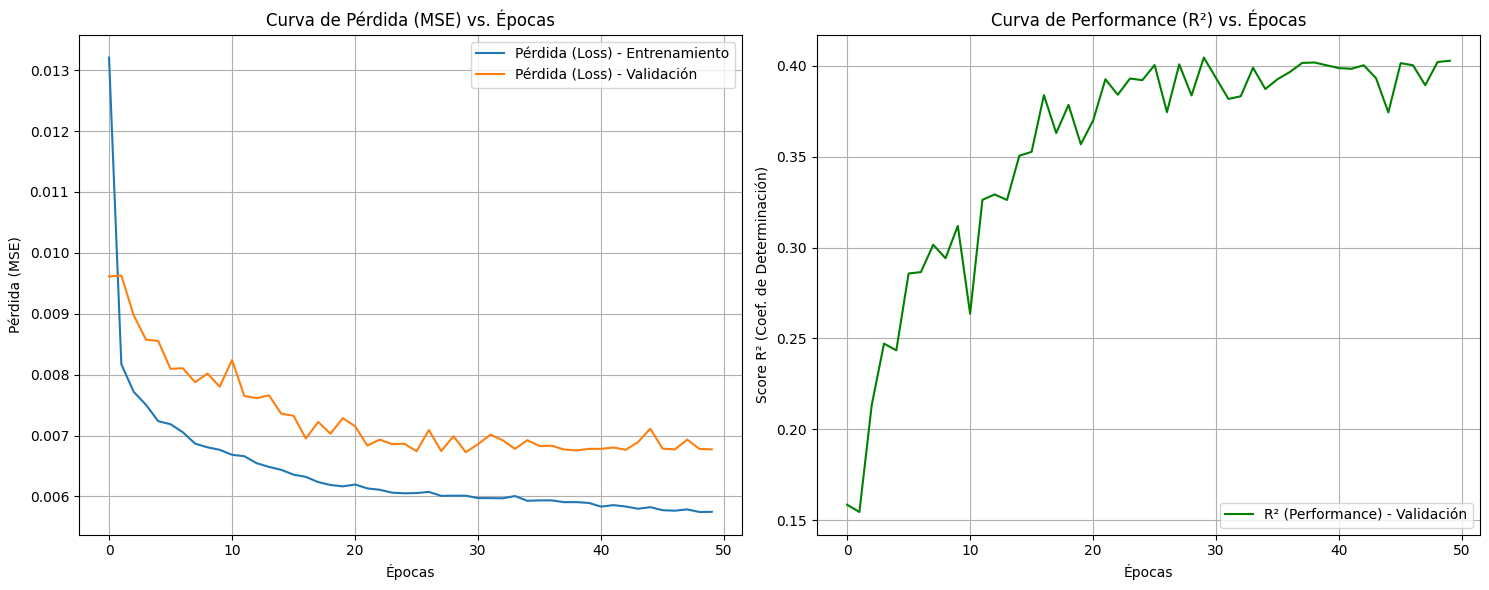

In [22]:
plt.figure(figsize=(15, 6))

#(MSE)
plt.subplot(1, 2, 1) 
plt.plot(history_loss, label='Pérdida (Loss) - Entrenamiento')
plt.plot(history_val_loss, label='Pérdida (Loss) - Validación')
plt.title('Curva de Pérdida (MSE) vs. Épocas')
plt.ylabel('Pérdida (MSE)')
plt.xlabel('Épocas')
plt.legend(loc='upper right')
plt.grid(True)

# Curva de Performance
plt.subplot(1, 2, 2) 
plt.plot(history_r2_score, label='R² (Performance) - Validación', color='green')
plt.title('Curva de Performance (R²) vs. Épocas')
plt.ylabel('Score R² (Coef. de Determinación)')
plt.xlabel('Épocas')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout() 
plt.show()


Métricas Finales del Modelo
  Score R² (Test):     0.6103
  Error (MAE Test):    1.2046 (Unidades de Demanda)
  Error (RMSE Test):   1.8331 (Unidades de Demanda)

El MAE significa que, en promedio, las predicciones del modelo
se desvían en 1.20 unidades de la demanda real.


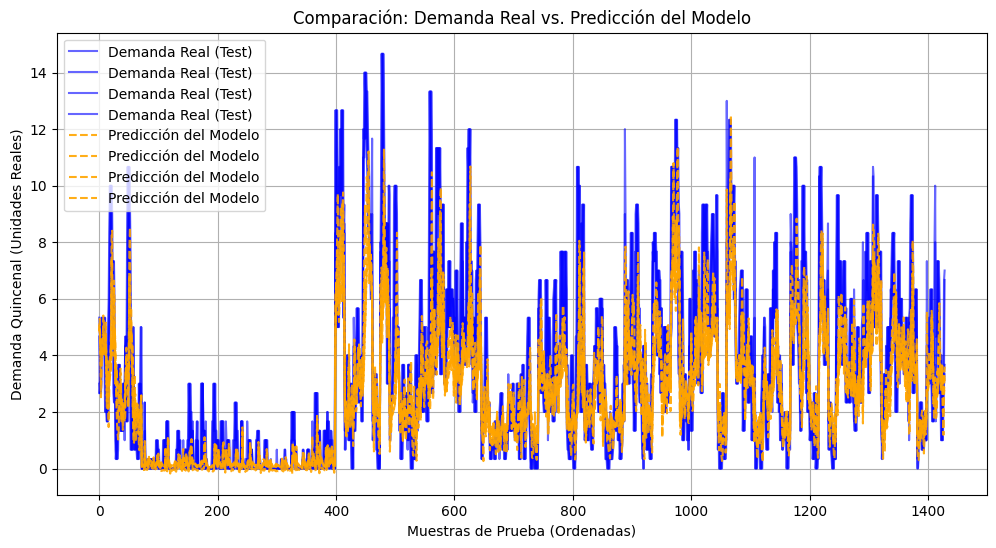

In [23]:
model.eval() 

all_y_test = []
all_outputs_test = []

with torch.no_grad(): 
    for batch_X_test, batch_Y_test in test_loader:
        outputs_test = model(batch_X_test)
        all_y_test.append(batch_Y_test.cpu())
        all_outputs_test.append(outputs_test.cpu())

all_y_test = torch.cat(all_y_test).numpy()
all_outputs_test = torch.cat(all_outputs_test).numpy()

#Deshacer escalado
y_test_log = scaler_y.inverse_transform(all_y_test)
y_pred_log = scaler_y.inverse_transform(all_outputs_test)

#Deshacer el logaritmo
y_test_real = np.expm1(y_test_log)
y_pred_real = np.expm1(y_pred_log)

test_mse = mean_squared_error(y_test_real, y_pred_real)
test_rmse = np.sqrt(test_mse) 
test_mae = mean_absolute_error(y_test_real, y_pred_real)
test_r2 = r2_score(y_test_real, y_pred_real)

print("\nMétricas Finales del Modelo")
print(f"  Score R² (Test):     {test_r2:.4f}")
print(f"  Error (MAE Test):    {test_mae:.4f} (Unidades de Demanda)")
print(f"  Error (RMSE Test):   {test_rmse:.4f} (Unidades de Demanda)")
print("\nEl MAE significa que, en promedio, las predicciones del modelo")
print(f"se desvían en {test_mae:.2f} unidades de la demanda real.")

# Gráfica de Comparación
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Demanda Real (Test)', color='blue', alpha=0.6)
plt.plot(y_pred_real, label='Predicción del Modelo', color='orange', linestyle='--', alpha=0.9)
plt.title('Comparación: Demanda Real vs. Predicción del Modelo')
plt.ylabel('Demanda Quincenal (Unidades Reales)')
plt.xlabel('Muestras de Prueba (Ordenadas)')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
import torch

NOMBRE_DEL_ARCHIVO = "Categ 0.61"

# --- GUARDAR ---
# Guardamos los pesos del modelo que está actualmente en memoria
try:
    torch.save(model.state_dict(), NOMBRE_DEL_ARCHIVO)
    print(f"✅ ¡Modelo guardado exitosamente!")
    print(f"📂 Nombre del archivo: {NOMBRE_DEL_ARCHIVO}")
    print("Guárdalo bien, este es tu 'Cerebro' entrenado.")
except NameError:
    print("⚠️ Error: No se encontró la variable 'model'. Asegúrate de haber terminado el entrenamiento.")

✅ ¡Modelo guardado exitosamente!
📂 Nombre del archivo: Categ 0.61
Guárdalo bien, este es tu 'Cerebro' entrenado.


In [27]:
def predecir_categoria_y_graficar(
    categoria,
    start_index=0,
    usar_ultimas_ventanas=False,
    input_steps=INPUT_WIDTH,
    output_steps=LABEL_WIDTH
):
    """
    Predice 'output_steps' quincenas futuras para TODOS los SKU de una categoría,
    suma la predicción y la realidad a nivel categoría
    y grafica Pred vs Real + imprime detalle por SKU.

    - categoria: nombre exacto de la categoría (ej. 'Lácteos')
    - start_index: índice de inicio (0 = primeras 6 quincenas y siguientes 4)
    - usar_ultimas_ventanas: si True, ignora start_index y usa la última ventana posible
    """

    model.eval()
    
    # 1) SKUs de la categoría
    skus_cat = df_final.loc[df_final['Categoria'] == categoria, 'SKU'].unique()
    skus_cat = np.sort(skus_cat)
    
    if len(skus_cat) == 0:
        print(f"No se encontraron SKUs para la categoría '{categoria}'.")
        return
    
    print(f"Categoría: {categoria}")
    print(f"SKUs en la categoría: {len(skus_cat)}")
    
    # Acumuladores para la categoría
    pred_cat = None
    real_cat = None
    fechas_futuro = None
    
    filas_detalle = []
    
    # 2) Iterar por cada SKU
    for sku in skus_cat:
        df_sku = df_final[df_final['SKU'] == sku].sort_values('Fecha').reset_index(drop=True)
        n = len(df_sku)
        
        # Determinar start_index real
        if usar_ultimas_ventanas:
            # última ventana posible: n - (input_steps + output_steps)
            si = n - (input_steps + output_steps)
            if si < 0:
                # este SKU no tiene suficientes datos, lo saltamos
                continue
        else:
            si = start_index
        
        if n < si + input_steps + output_steps:
            # no hay suficientes datos para este SKU en ese índice
            continue
        
        # Ventana de historia (6 quincenas)
        ventana_input = df_sku.iloc[si : si + input_steps]
        # Ventana de futuro real (4 quincenas)
        ventana_futuro = df_sku.iloc[si + input_steps : si + input_steps + output_steps]
        
        # --- 2.1 Preparar X para el modelo ---
        features_reales = ventana_input[FEATURES].values  # sin escalar
        features_scaled = scaler_x.transform(features_reales)
        input_tensor = torch.tensor(features_scaled[np.newaxis, :, :]).float()
        
        # --- 2.2 Predicción ---
        with torch.no_grad():
            pred_scaled = model(input_tensor).numpy().flatten()  # (output_steps,)
        
        # Invertimos el escalado del target (Demanda_Log)
        pred_log = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).ravel()
        pred_unidades = np.expm1(pred_log)  # volver a unidades
        
        # Real (usamos Demanda_Log para ser consistentes)
        real_log = ventana_futuro['Demanda_Log'].values
        real_unidades = np.expm1(real_log)
        
        fechas_futuro_sku = ventana_futuro['Fecha'].values
        
        # Acumular categoría
        if pred_cat is None:
            pred_cat = pred_unidades.copy()
            real_cat = real_unidades.copy()
            fechas_futuro = fechas_futuro_sku
        else:
            pred_cat += pred_unidades
            real_cat += real_unidades
        
        # Detalle por SKU
        for i in range(output_steps):
            filas_detalle.append({
                'Categoria': categoria,
                'SKU': sku,
                'Fecha': fechas_futuro_sku[i],
                'Predicción_unidades': pred_unidades[i],
                'Real_unidades': real_unidades[i]
            })
    
    if pred_cat is None:
        print("Ningún SKU tiene suficientes datos para esa ventana de tiempo.")
        return
    
    # 3) Serie histórica agregada de la categoría (para mostrar las 6 quincenas previas)
    df_cat = df_final[df_final['Categoria'] == categoria].copy()
    df_cat['Unidades'] = np.expm1(df_cat['Demanda_Log'])
    df_cat_agg = (
        df_cat.groupby('Fecha')['Unidades']
        .sum()
        .reset_index()
        .sort_values('Fecha')
        .reset_index(drop=True)
    )
    
    # Ajustar start_index para la serie agregada si hace falta
    if usar_ultimas_ventanas:
        si_cat = len(df_cat_agg) - (input_steps + output_steps)
        if si_cat < 0:
            print("La categoría no tiene suficientes quincenas en total.")
            return
    else:
        si_cat = start_index
    
    if len(df_cat_agg) < si_cat + input_steps + output_steps:
        print("La categoría no tiene suficientes quincenas para esa ventana.")
        return
    
    ventana_cat = df_cat_agg.iloc[si_cat : si_cat + input_steps + output_steps]
    historia_cat = ventana_cat.iloc[:input_steps]
    
    fechas_historia = historia_cat['Fecha'].values
    historia_unidades = historia_cat['Unidades'].values
    
    # 4) R² a nivel categoría
    r2_cat = r2_score(real_cat, pred_cat)
    
    # 5) Gráfica
    plt.figure(figsize=(12, 6))
    
    plt.plot(fechas_historia, historia_unidades,
             label='Historia categoría (6 quincenas)',
             marker='o')
    
    plt.plot(fechas_futuro, real_cat,
             label='Realidad futura categoría (4 quincenas)',
             marker='o', linewidth=2)
    
    plt.plot(fechas_futuro, pred_cat,
             label='Predicción modelo categoría (4 quincenas)',
             linestyle='--', marker='x', linewidth=2)
    
    plt.title(f"Categoría: {categoria} - Predicción de demanda total (R² = {r2_cat:.3f})")
    plt.ylabel("Demanda total categoría (unidades)")
    plt.xlabel("Fecha")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    for i, y in enumerate(pred_cat):
        plt.annotate(f"{y:.0f}", (fechas_futuro[i], pred_cat[i]),
                     xytext=(0, 8), textcoords='offset points')
    
    plt.show()
    
    # 6) Resumen categoría
    print("\n==============================")
    print(f"Categoría: {categoria}")
    print(f"Demanda TOTAL REAL (4 quincenas) de todos los productos: {real_cat.sum():.0f} unidades")
    print(f"Demanda TOTAL PREDICHA (4 quincenas) de todos los productos: {pred_cat.sum():.0f} unidades")
    print("==============================")
    print("Detalle por quincena (categoría):")
    for i, f in enumerate(fechas_futuro):
        # Convertimos numpy.datetime64 a string legible
        # (necesitas tener import pandas as pd arriba)
        fecha_str = pd.to_datetime(f).strftime("%Y-%m-%d")
        print(f"  {fecha_str}: Real={real_cat[i]:.0f} | Pred={pred_cat[i]:.0f}")

    
    # 7) Detalle por SKU
    df_detalle = pd.DataFrame(filas_detalle).sort_values(['Fecha', 'SKU'])
    print("\nDetalle por SKU y fecha (primeras filas):")
    print(df_detalle.head(20))
    
    return df_detalle, pred_cat, real_cat, fechas_futuro


Categoría: Lácteos
SKUs en la categoría: 180


c:\Users\Angel Diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Angel Diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Angel Diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Angel Diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Angel Diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\vali

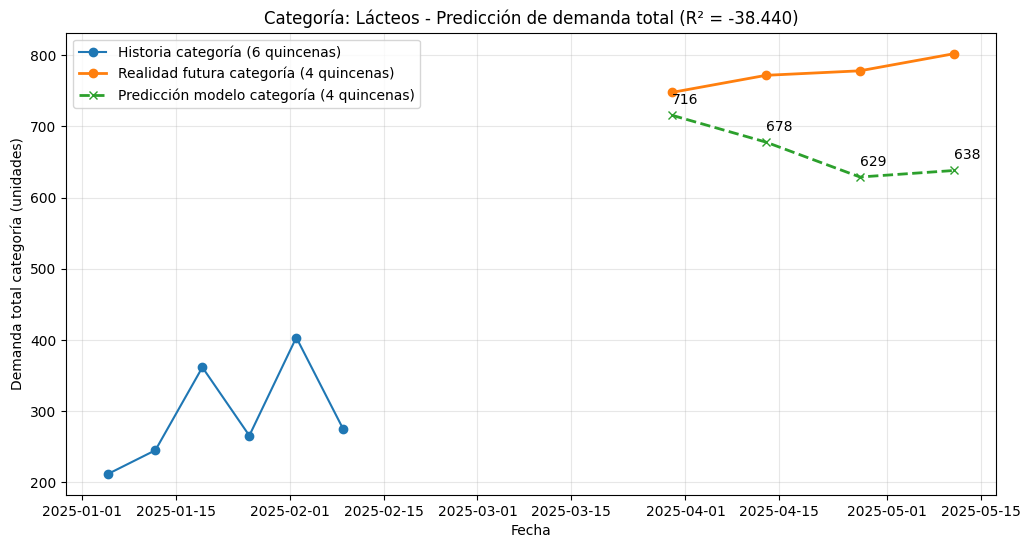


Categoría: Lácteos
Demanda TOTAL REAL (4 quincenas) de todos los productos: 3099 unidades
Demanda TOTAL PREDICHA (4 quincenas) de todos los productos: 2660 unidades
Detalle por quincena (categoría):
  2025-03-30: Real=748 | Pred=716
  2025-04-13: Real=772 | Pred=678
  2025-04-27: Real=778 | Pred=629
  2025-05-11: Real=802 | Pred=638

Detalle por SKU y fecha (primeras filas):
    Categoria       SKU      Fecha  Predicción_unidades  Real_unidades
0     Lácteos  SKU-0015 2025-03-30             2.889708       4.000000
4     Lácteos  SKU-0216 2025-03-30             4.753869       4.333333
8     Lácteos  SKU-0217 2025-03-30             3.523539       4.000000
32    Lácteos  SKU-0223 2025-03-30             1.607936       1.333333
44    Lácteos  SKU-0226 2025-03-30             2.638390       2.333333
48    Lácteos  SKU-0227 2025-03-30             8.865884       8.333333
52    Lácteos  SKU-0228 2025-03-30             9.699868       9.666667
56    Lácteos  SKU-0229 2025-03-30             2.3345

c:\Users\Angel Diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Angel Diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Angel Diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Angel Diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Angel Diaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\vali

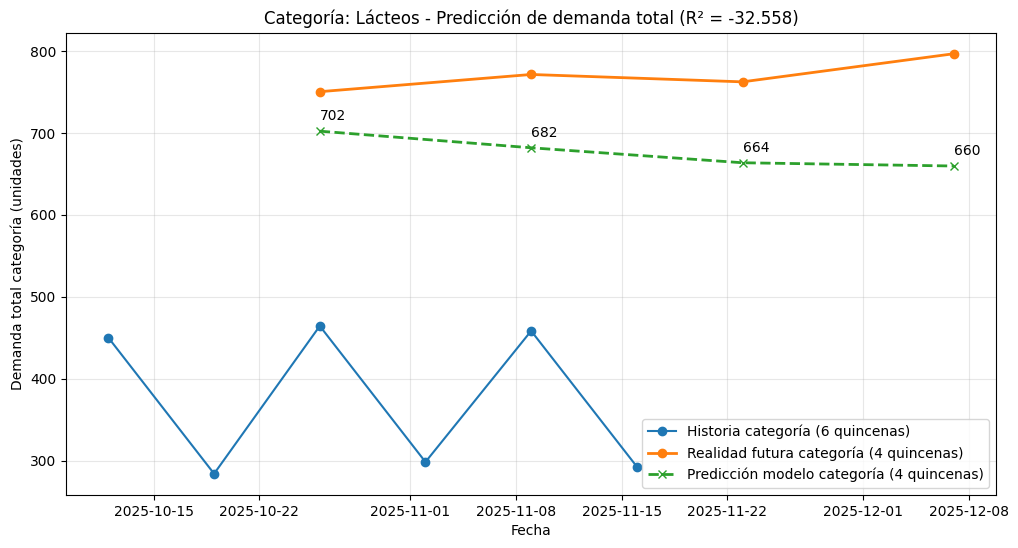


Categoría: Lácteos
Demanda TOTAL REAL (4 quincenas) de todos los productos: 3081 unidades
Demanda TOTAL PREDICHA (4 quincenas) de todos los productos: 2707 unidades
Detalle por quincena (categoría):
  2025-10-26: Real=750 | Pred=702
  2025-11-09: Real=771 | Pred=682
  2025-11-23: Real=762 | Pred=664
  2025-12-07: Real=797 | Pred=660

Detalle por SKU y fecha (primeras filas):
    Categoria       SKU      Fecha  Predicción_unidades  Real_unidades
584   Lácteos  SKU-0361 2025-08-17             1.481163       2.000000
328   Lácteos  SKU-0297 2025-08-31             3.172354       2.000000
585   Lácteos  SKU-0361 2025-08-31             2.585561       4.000000
329   Lácteos  SKU-0297 2025-09-14             3.014956       2.333333
516   Lácteos  SKU-0344 2025-09-14             3.435638       3.666667
586   Lácteos  SKU-0361 2025-09-14             2.454683       4.000000
484   Lácteos  SKU-0336 2025-09-21             4.086587       4.333333
708   Lácteos  SKU-0392 2025-09-21             2.7163

(    Categoria       SKU      Fecha  Predicción_unidades  Real_unidades
 584   Lácteos  SKU-0361 2025-08-17             1.481163       2.000000
 328   Lácteos  SKU-0297 2025-08-31             3.172354       2.000000
 585   Lácteos  SKU-0361 2025-08-31             2.585561       4.000000
 329   Lácteos  SKU-0297 2025-09-14             3.014956       2.333333
 516   Lácteos  SKU-0344 2025-09-14             3.435638       3.666667
 ..        ...       ...        ...                  ...            ...
 647   Lácteos  SKU-0376 2025-12-14             3.104711       4.000000
 651   Lácteos  SKU-0377 2025-12-14             4.125359       4.333333
 679   Lácteos  SKU-0384 2025-12-14             3.807809       3.000000
 683   Lácteos  SKU-0385 2025-12-14             3.003513       0.666667
 707   Lácteos  SKU-0391 2025-12-14             1.255025       2.000000
 
 [720 rows x 5 columns],
 array([702.12946, 681.8451 , 663.57635, 659.60254], dtype=float32),
 array([750.33333333, 771.33333333, 762.

In [28]:
# Caso "metodología profe": primeras 6 quincenas y 4 siguientes
predecir_categoria_y_graficar('Lácteos', start_index=0, usar_ultimas_ventanas=False)

# Caso "más intuitivo para negocio": últimas 6 quincenas y 4 siguientes
predecir_categoria_y_graficar('Lácteos', usar_ultimas_ventanas=True)
